<a href="https://colab.research.google.com/github/sangttruong/Cummins/blob/master/InterestIncome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Quantitative Approach for Forecasting Interest Income**
*Author: Sang Truong, Treasury Co-Op Analyst*

Cummins Inc., Columbus, IN, 2019

**Abstract:** Interest income of Cummins in the period to 2009 and 2019 does not appear to have seasional behavior. Many entities have a good underlying interest income structure, but many do not. Interest income for most entities negatively correlate with it corresponded cash balance. It is not necessary that the stronggest correlation occurs between interest income and cash balance in the same period.

# **Section 1. Introduction**

In [0]:
# Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.tsa.stattools as stattools
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.statespace.sarimax as sarimax
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from contextlib import contextmanager
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os, sys
import math

# Suppressing output of pip installation
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try: yield
        finally: sys.stdout = old_stdout
            
with suppress_stdout():
  ! pip install pmdarima
  ! pip install tbats
  from pmdarima import auto_arima
  from tbats import TBATS, BATS
  drive.mount('/content/gdrive')
  path = 'gdrive/My Drive/Colab Notebooks/InterestForecast/'

# Load raw data
raw = pd.ExcelFile(path + 'raw.xlsx')

# Primary variable
interest = pd.read_excel(raw, 'interest')
interest.name = 'interest'

# Secondary variable
cash = pd.read_excel(raw, 'cash')
cash.name = 'cash'
rate = pd.read_excel(raw, 'rate')
rate.name = 'rate'

In [17]:
interest.head(5)

,Month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,2009-01-01,-641885.0,-101098.0,-540787.0,-237577.0,-7471.0,0,-10.0,-6078.0,0.0,-49785.0,0.0,0,-126.0,0.0,0.0,0.0,-31.0,-174076.0,0.0,-303210.0,-622,-5948.0,0,0,-31304.0,0.0,-4130.0,0.0,0.0,-184444.0,239.0,-832.0,-1266.0,0,0,0.0,-73075.0,-1073.0,0.0,-645.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,2009-02-01,-544797.0,-93116.0,-451681.0,-118417.0,-3136.0,8572,-229.0,-1472.0,-3924.0,-21512.0,-1849.0,0,-656.0,0.0,0.0,-3.0,-17.0,-93800.0,0.0,-333264.0,572,-8299.0,0,-90,-13390.0,0.0,-22097.0,0.0,0.0,-202629.0,-2313.0,-1266.0,-677.0,0,0,0.0,-83030.0,-43.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,2009-03-01,-966395.0,-105875.0,-860520.0,-168958.0,-1407.0,-8090,-222.0,-8570.0,-665.0,-7430.0,-2288.0,0,-1168.0,0.0,-704.0,-439.0,0.0,-137874.0,0.0,-691562.0,-7982,3084.0,0,-120,-7822.0,0.0,-202783.0,0.0,0.0,-382045.0,-592.0,-491.0,-4394.0,0,0,0.0,-88288.0,-82.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,2009-04-01,-460750.0,-98066.0,-362684.0,49352.0,2439.0,22497,-1347.0,23183.0,-1145.0,-10052.0,-8329.0,0,14566.0,0.0,-1.0,119.0,0.0,7936.0,0.0,-412036.0,-18,-26854.0,0,0,-23162.0,0.0,-40794.0,0.0,0.0,-211859.0,-402.0,-514.0,-2703.0,0,0,0.0,-110924.0,5490.0,0.0,-265.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,2009-05-01,-345760.0,-53510.0,-292250.0,5576.0,83933.0,4097,-1491.0,5187.0,-2716.0,-4776.0,-2431.0,0,5847.0,0.0,-260.0,911.0,-5.0,-82711.0,0.0,-297826.0,0,-60141.0,0,-94,-6679.0,0.0,7654.0,0.0,0.0,-128840.0,-525.0,-777.0,-3051.0,0,0,0.0,-108195.0,3150.0,0.0,-293.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [18]:
cash.head(5)

,Month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29-NoInvest,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,2009-01-01,385061702.0,38191197.0,346870505.0,66163617.0,7784784.0,-4509587,3202492.0,-5680902.0,-3779078.0,11748693.0,6098650.0,226974,1021918.0,1218848.0,-753822.0,869379.0,193036.0,48029013.0,0.0,280706888.0,672648.0,-7834799.0,155190,57460,16123032.0,40842.0,149331638.0,0.0,47755.0,14921261.0,77187405.0,9055761.0,3850297.0,1393971.0,0,0,937183.0,12628309.0,57357363.0,0.0,1011683.0,19327583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,2009-02-01,408259699.0,135605490.0,272654209.0,64313034.0,9306412.0,-3877848,3687752.0,-5548928.0,-1287951.0,10373278.0,5955635.0,1055679,-7019613.0,744698.0,-1633959.0,282077.0,236190.0,51872812.0,0.0,208341175.0,321443.0,-41755275.0,101306,454545,2471276.0,-16659.0,116514887.0,0.0,2197990.0,9954319.0,80239965.0,5488393.0,3196344.0,8179512.0,0,0,856666.0,13495821.0,61042111.0,0.0,1301696.0,22607403.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,2009-03-01,352110542.0,60108776.0,292001766.0,83645287.0,591770.0,-4105240,4714266.0,-9683459.0,-1825578.0,12278610.0,6088681.0,286295,-7936470.0,1432573.0,-1247227.0,-533050.0,160237.0,83171930.0,0.0,208356479.0,582609.0,-65909425.0,94944,232060,11468364.0,37932.0,154226124.0,0.0,466550.0,23467725.0,65200020.0,1245372.0,3453867.0,3964036.0,0,0,136946.0,14561433.0,53547451.0,0.0,227911.0,5236476.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,2009-04-01,364900545.0,64267263.0,300633282.0,117415092.0,3814252.0,-4074255,4604193.0,-4248698.0,-2054398.0,12468369.0,7966845.0,142821,-8376674.0,830802.0,-2289079.0,-415766.0,80427.0,108335932.0,0.0,183218190.0,626437.0,-62906442.0,117975,155464,15720826.0,8566.0,124608379.0,0.0,456126.0,16589305.0,91035872.0,6235055.0,2758224.0,1811944.0,0,0,241299.0,18315310.0,59095479.0,0.0,-2636601.0,350453.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,2009-05-01,382094228.0,46913352.0,335180876.0,158351314.0,-142476.0,-4156705,5632322.0,-23019.0,-3523926.0,5029363.0,6808025.0,118999,-7150130.0,948072.0,-1995867.0,-393908.0,148929.0,156295651.0,0.0,176829562.0,468752.0,-70270776.0,11032,163931,20391707.0,116707.0,120318836.0,0.0,555613.0,24449218.0,111949945.0,8230461.0,2615411.0,3270778.0,0,0,239269.0,18557043.0,44345878.0,0.0,-2218106.0,4029876.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [19]:
rate.head(5)

,Month,0,1,26,29,ROW,UKplus
0,2009-01-01,0.15,0.15,0.15,6.50,0.15,0.15
1,2009-02-01,0.22,0.22,0.22,5.50,0.22,0.22
2,2009-03-01,0.18,0.18,0.18,5.00,0.18,0.18
3,2009-04-01,0.15,0.15,0.15,4.75,0.15,0.15
4,2009-05-01,0.18,0.18,0.18,4.75,0.18,0.18


In [0]:
# Split data for model training at train_stop
train_stop = 115
train_interest = interest.iloc[:train_stop]
test_interest = interest.iloc[train_stop:]
train_cash = cash.iloc[:train_stop]
test_cash = cash.iloc[train_stop:]
train_rate = rate.iloc[:train_stop]
test_rate = rate.iloc[train_stop:]

# **Section 2. Moving Average**

In this section, we explore the use of naive moving average in forecasting interest income. 

In [0]:
def naive(i, k):
  naive = pd.DataFrame(columns = ['Month', 'Interest', 'Naive pred'])
  naive['Month'] = interest['Month']
  naive['Interest'] = interest[i]

  for j in range(k, len(naive)-12):
    naive.loc[j, 'Naive pred'] = interest.loc[(j-k):(j-1), i].mean()

  for j in range(len(naive)-12, len(naive)):
    naive.loc[j, 'Naive pred'] = naive.loc[(j-k):(j-1), 'Naive pred'].mean()

    # Error
  rmse_train_sarimax = math.sqrt(sum((naive.loc[:(len(naive)-12), 'Naive pred']-naive.loc[:(len(naive)-12), 'Interest'])**2)/len(naive.loc[(len(naive)-12):(len(naive)), 'Interest']))
  rmse_test_sarimax = math.sqrt(sum((naive.loc[(len(naive)-12):(len(naive)), 'Naive pred']-naive.loc[(len(naive)-12):(len(naive)), 'Interest'])**2)/len(naive.loc[(len(naive)-12):(len(naive)), 'Interest']))

  print("rmse_train_sarimax", rmse_train_sarimax)
  print("rmse_test_sarimax", rmse_test_sarimax)

  plt.figure(figsize=(15,7))
  plt.plot(interest.iloc[:,0], interest[i], label = 'Real interest', color = 'blue')
  plt.plot(naive.loc[:(len(naive)-12), 'Month'], naive.loc[:(len(naive)-12), 'Naive pred'],
          label = 'In-sample forecast', color = 'green')
  plt.plot(naive.loc[(len(naive)-12):(len(naive)), 'Month'], naive.loc[(len(naive)-12):(len(naive)), 'Naive pred'],
          label = 'Out-of-sample forecast', color = 'red')
  plt.legend()
  plt.savefig(path + 'naive' + 'i' + str(i) + 'k' + str(k) + '.png', quality = 100, dpi = 1000)
  plt.show()

rmse_train_sarimax nan
rmse_test_sarimax 641164.3970030545


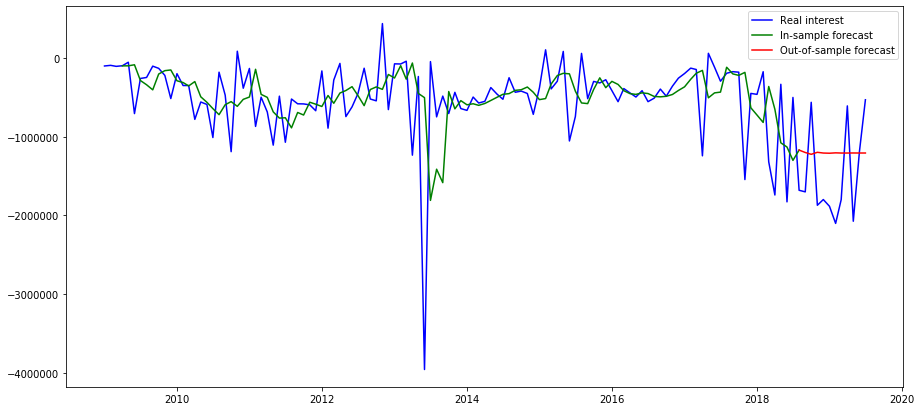

In [0]:
# US
naive(i = 1, k = 3)

rmse_train_sarimax nan
rmse_test_sarimax 694772.3759014348


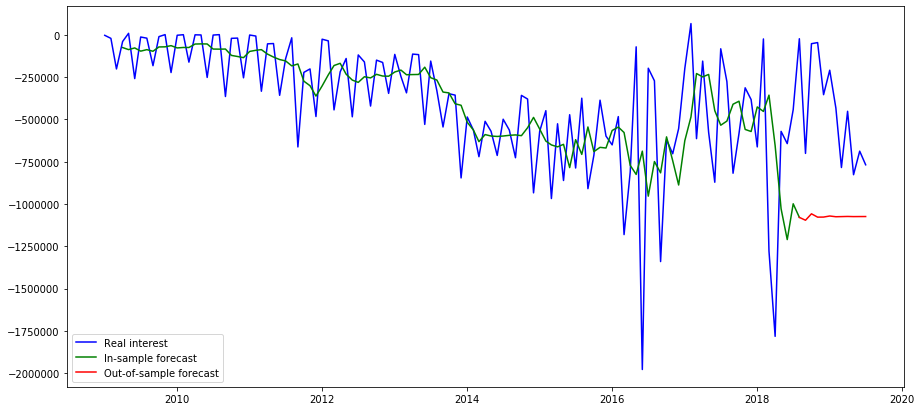

In [0]:
# China
naive(i = 26, k = 3)

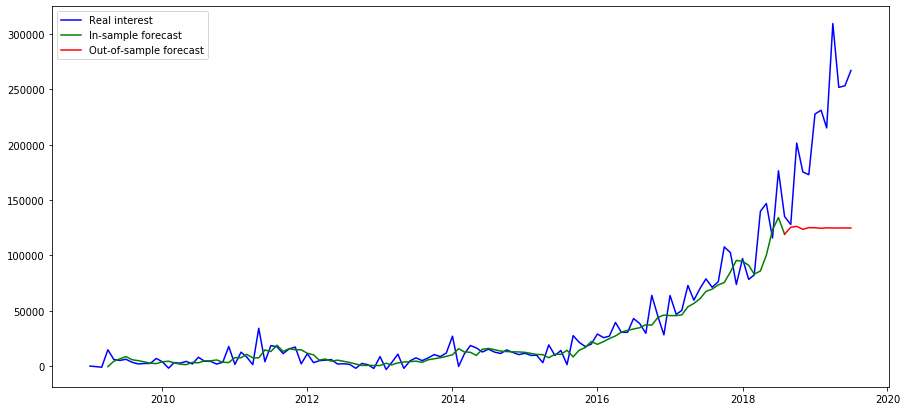

In [0]:
# Romania
naive(i = 12, k = 3)

rmse_train_sarimax nan
rmse_test_sarimax 494915.05622678157


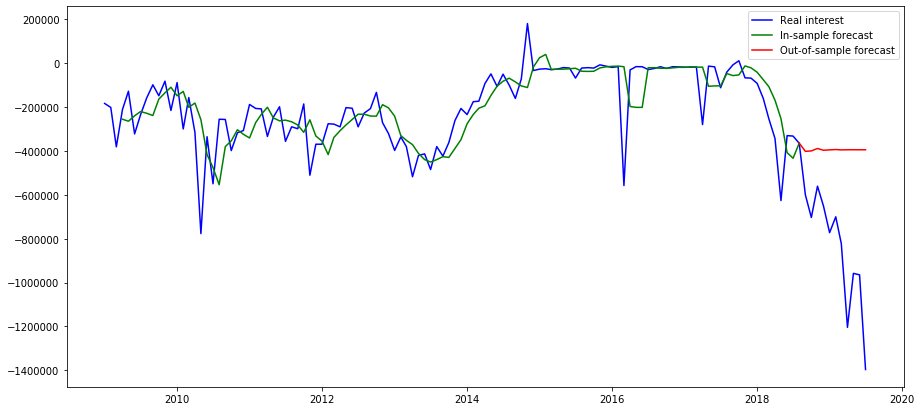

In [0]:
India
naive(i = 29, k = 3)

# **Section 3. SARIMAX**

In [0]:
def arima(i, train_y, test_y, train_x = None, test_x = None):
  # Automatically fit model to train y
  arima = auto_arima(train_y[i], exogenous = train_x,
                     start_p=0, d=None, start_q=0, max_p=5, max_d=2, max_q=5,
                     suppress_warnings = True)

  # In-sample forecast
  insample_pred = arima.predict_in_sample(exogenous = train_x)
  # print(insample_pred)
  # print(len(insample_pred))
  # print(len(train_y))


  # Multi-step out-of-sample forecast
  outsample_pred = arima.predict(n_periods=12, exogenous = test_x, return_conf_int = True)
  lower_ci, upper_ci = outsample_pred[1].T

  outsample_pred_value = outsample_pred[0]
  # print(len(outsample_pred_value))
  # print(len(test_y))

  # Plot
  plt.figure(figsize=(15,7))
  plt.plot(train_y.iloc[:,0], train_y[i], label = 'Real', color='blue')
  plt.plot(test_y.iloc[:,0], test_y[i], color='blue')
  plt.plot(train_y.iloc[:,0], insample_pred, label = 'In-sample forecast', color='green')
  plt.plot(test_y.iloc[:,0], outsample_pred[0], label = 'Out-of-sample forecast', color='red')
  plt.fill_between(test_y.iloc[:,0], lower_ci, upper_ci, color='k', alpha=.15)
  plt.legend()
  plt.savefig(path + str(i) + '.png', quality = 100, dpi = 1000)
  plt.show()

  # Error
  rmse_train_sarimax = math.sqrt(sum((insample_pred-train_y[i])**2)/len(train_y[i]))
  rmse_test_sarimax = math.sqrt(sum((outsample_pred_value-test_y[i])**2)/len(test_y[i]))

  print("rmse_train_sarimax", rmse_train_sarimax)
  print("rmse_test_sarimax", rmse_test_sarimax)

  # # Model result
  # print(arima.summary())

  return arima

I use `arima` function to forecast interest income of entity 1 (US) with and without the present of cash balance and US Federal fund rate. The result shows, for the US, ARIMAX outperforme ARIMA. For other entity outside of the US, the only exogenous variable for ARIMAX is cash balance since foreign countries interest rate does not necessary follow FFR.

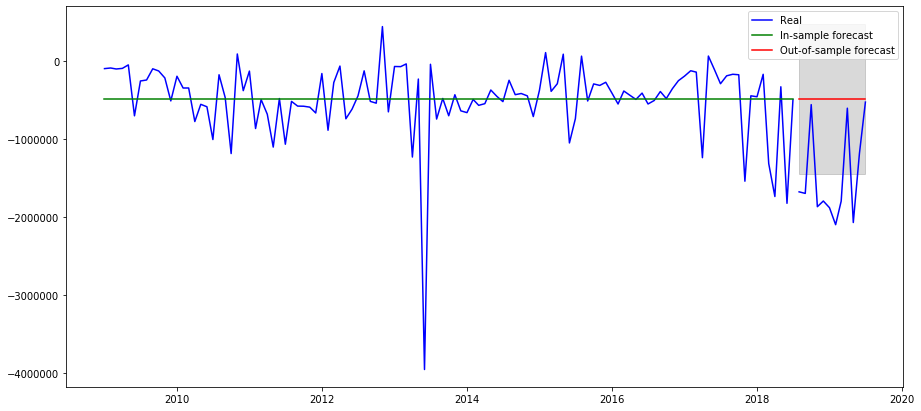

rmse_train_sarimax 491115.10066709964
rmse_test_sarimax 1150463.8322748267


ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
# US
i = 1
arima(i = i, train_y = train_interest, test_y = test_interest)

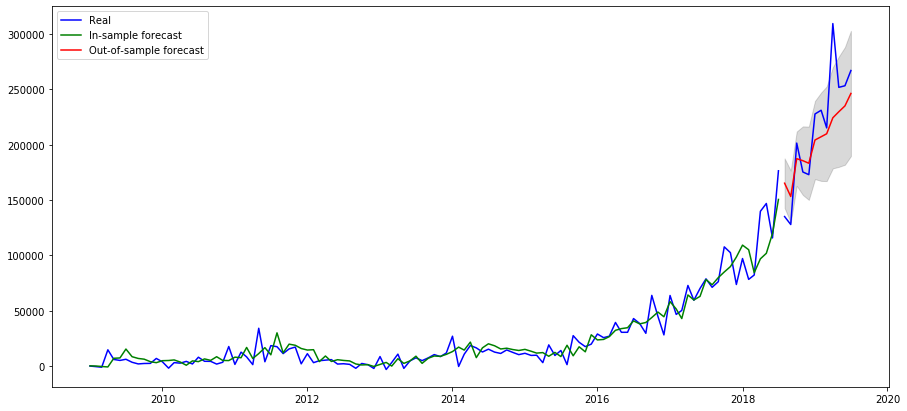

rmse_train_sarimax 10199.66548901878
rmse_test_sarimax 31099.843571871057


ARIMA(maxiter=50, method='lbfgs', order=(2, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
# Romania
i = 12
arima(i = i, train_y = train_interest, test_y = test_interest)

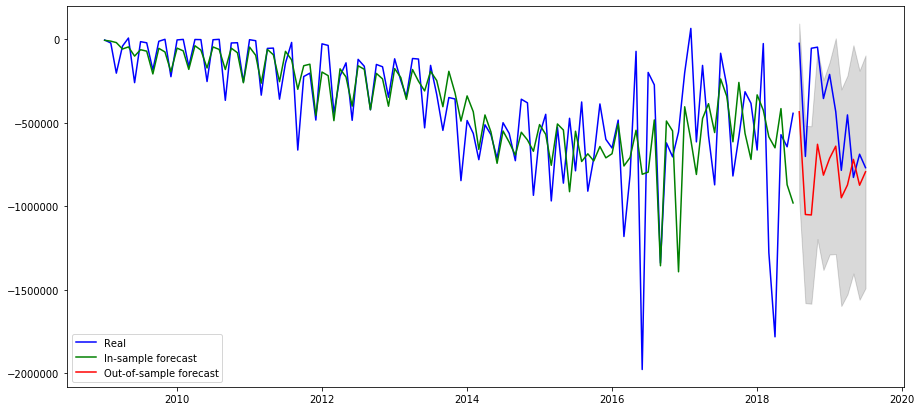

rmse_train_sarimax 263544.01628554676
rmse_test_sarimax 445460.77460628824


ARIMA(maxiter=50, method='lbfgs', order=(5, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
# China
i = 26
arima(i = i, train_y = train_interest, test_y = test_interest)

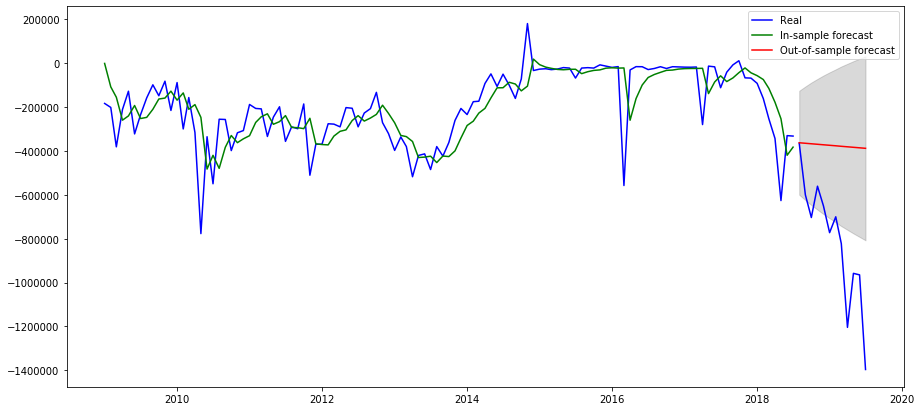

rmse_train_sarimax 121669.21012452654
rmse_test_sarimax 507884.3537288851


ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
# India
i = 29
arima(i = i, train_y = train_interest, test_y = test_interest)

# **Section 4. TBATS**

1072121.4269707822


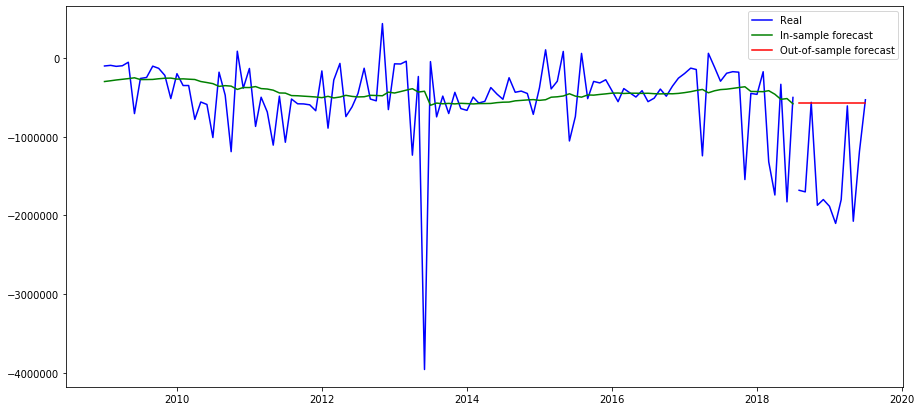

In [0]:
# Fit the model
i = 1
estimator = TBATS(use_box_cox = None, use_trend = None, use_damped_trend = None, use_arma_errors = True)
model = estimator.fit(train_interest[i])

# Predict
y_forecast = model.forecast(steps=len(test_interest[i]))

# Error
rmse_train_tbats = math.sqrt(sum((model.y_hat-train_interest[i])**2)/len(train_interest[i]))
rmse_test_tbats = math.sqrt(sum((y_forecast-test_interest[i])**2)/(len(test_interest[i])))

print(rmse_test_tbats)

# Residual
eTBATS = model.resid

# Plot
plt.figure(figsize=(15,7))
plt.plot(train_interest.iloc[:,0], train_interest[i], label = 'Real', color='blue')
plt.plot(test_interest.iloc[:,0], test_interest[i], color='blue')
plt.plot(train_interest.iloc[:,0], model.y_hat, label = 'In-sample forecast', color='green')
plt.plot(test_interest.iloc[:,0], y_forecast, label = 'Out-of-sample forecast', color='red')
# plt.fill_between(test_y.iloc[:,0], lower_ci, upper_ci, color='k', alpha=.15)
plt.legend()
plt.savefig(path + str(i) + 'TBATS.png', quality = 100, dpi = 1000)
plt.show()

31580.55885528354


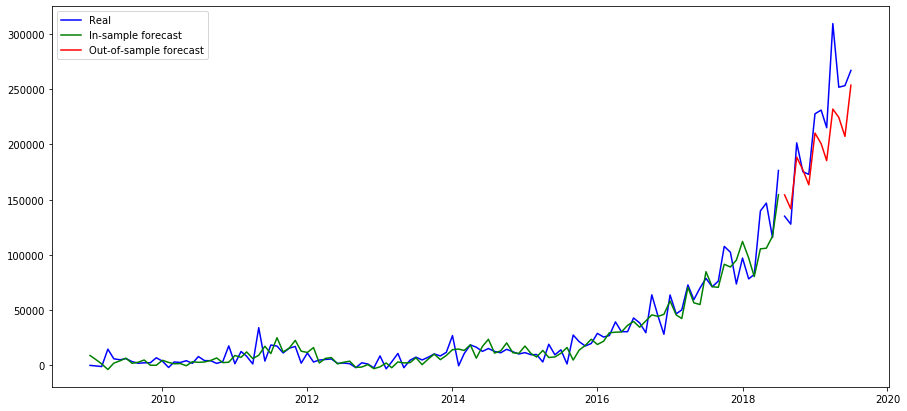

In [0]:
# Fit the model
i = 12
estimator = TBATS(use_box_cox = None, use_trend = None, use_damped_trend = None, use_arma_errors = True)
model = estimator.fit(train_interest[i])

# Predict
y_forecast = model.forecast(steps=len(test_interest[i]))

# Error
rmse_train_tbats = math.sqrt(sum((model.y_hat-train_interest[i])**2)/len(train_interest[i]))
rmse_test_tbats = math.sqrt(sum((y_forecast-test_interest[i])**2)/(len(test_interest[i])))

print(rmse_test_tbats)

# Residual
eTBATS = model.resid

# Plot
plt.figure(figsize=(15,7))
plt.plot(train_interest.iloc[:,0], train_interest[i], label = 'Real', color='blue')
plt.plot(test_interest.iloc[:,0], test_interest[i], color='blue')
plt.plot(train_interest.iloc[:,0], model.y_hat, label = 'In-sample forecast', color='green')
plt.plot(test_interest.iloc[:,0], y_forecast, label = 'Out-of-sample forecast', color='red')
# plt.fill_between(test_y.iloc[:,0], lower_ci, upper_ci, color='k', alpha=.15)
plt.legend()
plt.savefig(path + str(i) + 'TBATS.png', quality = 100, dpi = 1000)
plt.show()

423990.8870044595


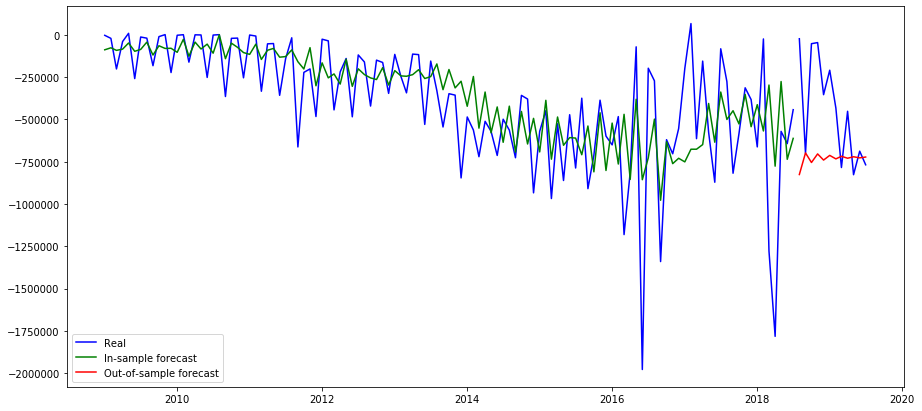

In [0]:
# Fit the model
i = 26
estimator = TBATS(use_box_cox = None, use_trend = None, use_damped_trend = None, use_arma_errors = True)
model = estimator.fit(train_interest[i])

# Predict
y_forecast = model.forecast(steps=len(test_interest[i]))

# Error
rmse_train_tbats = math.sqrt(sum((model.y_hat-train_interest[i])**2)/len(train_interest[i]))
rmse_test_tbats = math.sqrt(sum((y_forecast-test_interest[i])**2)/(len(test_interest[i])))

print(rmse_test_tbats)

# Residual
eTBATS = model.resid

# Plot
plt.figure(figsize=(15,7))
plt.plot(train_interest.iloc[:,0], train_interest[i], label = 'Real', color='blue')
plt.plot(test_interest.iloc[:,0], test_interest[i], color='blue')
plt.plot(train_interest.iloc[:,0], model.y_hat, label = 'In-sample forecast', color='green')
plt.plot(test_interest.iloc[:,0], y_forecast, label = 'Out-of-sample forecast', color='red')
# plt.fill_between(test_y.iloc[:,0], lower_ci, upper_ci, color='k', alpha=.15)
plt.legend()
plt.savefig(path + str(i) + 'TBATS.png', quality = 100, dpi = 1000)
plt.show()

527536.6381182598


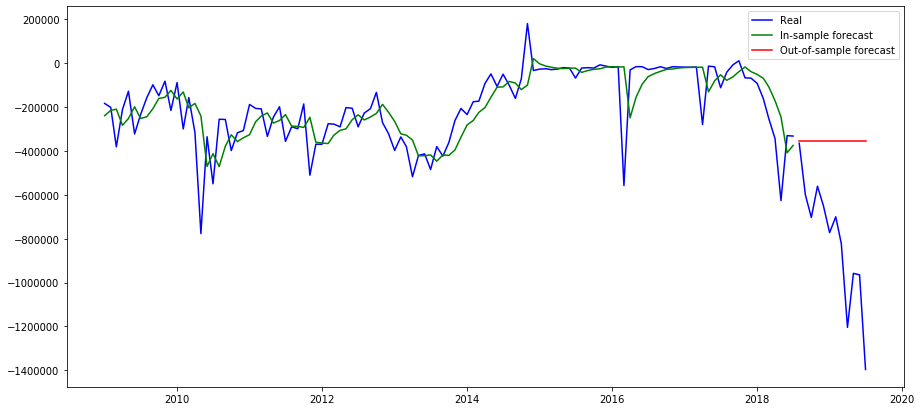

In [0]:
# Fit the model
i = 29
estimator = TBATS(use_box_cox = None, use_trend = None, use_damped_trend = None, use_arma_errors = True)
model = estimator.fit(train_interest[i])

# Predict
y_forecast = model.forecast(steps=len(test_interest[i]))

# Error
rmse_train_tbats = math.sqrt(sum((model.y_hat-train_interest[i])**2)/len(train_interest[i]))
rmse_test_tbats = math.sqrt(sum((y_forecast-test_interest[i])**2)/(len(test_interest[i])))

print(rmse_test_tbats)

# Residual
eTBATS = model.resid

# Plot
plt.figure(figsize=(15,7))
plt.plot(train_interest.iloc[:,0], train_interest[i], label = 'Real', color='blue')
plt.plot(test_interest.iloc[:,0], test_interest[i], color='blue')
plt.plot(train_interest.iloc[:,0], model.y_hat, label = 'In-sample forecast', color='green')
plt.plot(test_interest.iloc[:,0], y_forecast, label = 'Out-of-sample forecast', color='red')
# plt.fill_between(test_y.iloc[:,0], lower_ci, upper_ci, color='k', alpha=.15)
plt.legend()
plt.savefig(path + str(i) + 'TBATS.png', quality = 100, dpi = 1000)
plt.show()

# **Section 5.1 SARIMAX with X**

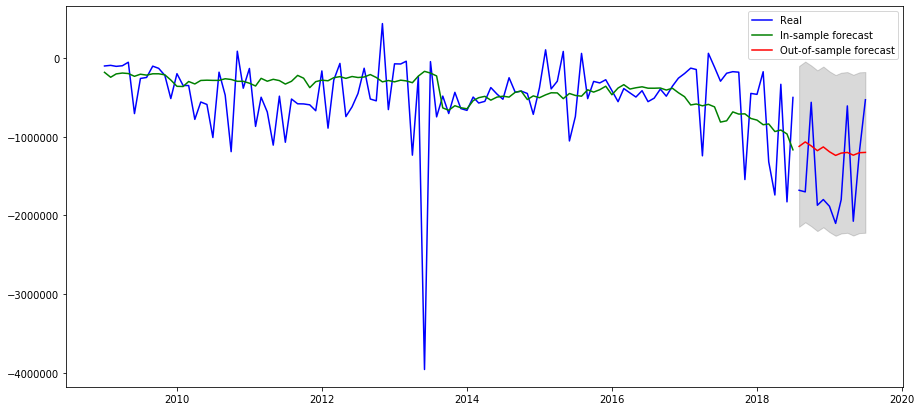

rmse_train_sarimax 513994.13159251004
rmse_test_sarimax 647485.9535866926


ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
# US
i = 1
train_x = pd.merge(train_cash[i], train_rate[i], left_index=True, right_index=True)
test_x = pd.merge(test_cash[i], test_rate[i], left_index=True, right_index=True)
arima(i = i, train_y = train_interest, test_y = test_interest, train_x = train_x, test_x = test_x)

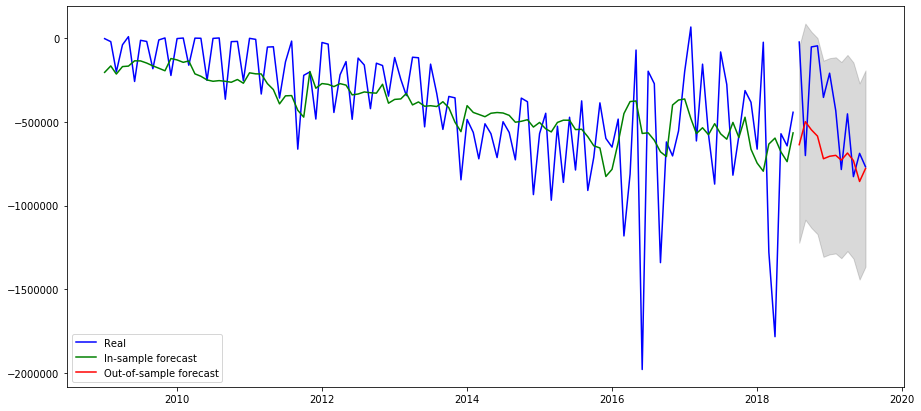

rmse_train_sarimax 298062.3847009355
rmse_test_sarimax 353126.66874593566


ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
# China
i = 26
train_x = pd.merge(train_cash[i], train_rate[i], left_index=True, right_index=True)
test_x = pd.merge(test_cash[i], test_rate[i], left_index=True, right_index=True)
arima(i = i, train_y = train_interest, test_y = test_interest, train_x = train_x, test_x = test_x)

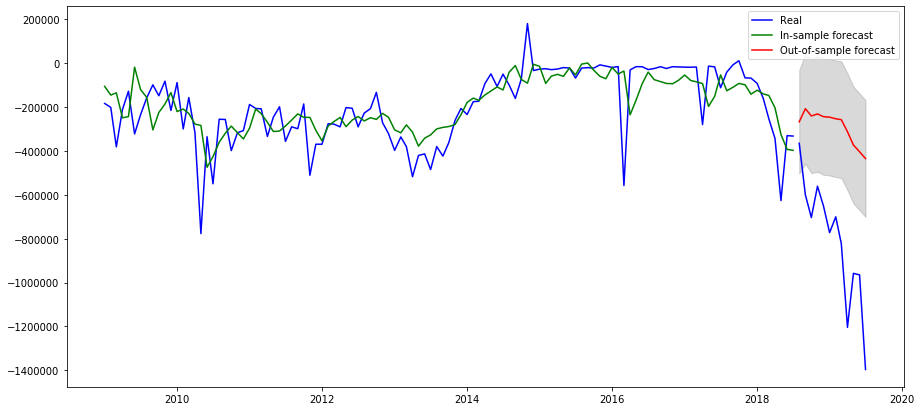

rmse_train_sarimax 119417.68160114919
rmse_test_sarimax 563933.3129860888


ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
# India
i = 29
train_x = pd.merge(train_cash[i], train_rate[i], left_index=True, right_index=True)
test_x = pd.merge(test_cash[i], test_rate[i], left_index=True, right_index=True)
arima(i = i, train_y = train_interest, test_y = test_interest, train_x = train_x, test_x = test_x)

# **Section 5.2 Cash forecast**

For 1 year ahead forecasting interest income (for example, in the US with ID = 1), we need to give the model data about cash balance and FFR rate of 1 year ahead. However, we don't always have these information at the focasting point. Therefore, we need to perform cash balance forecast and FFR forecast.

For cash balance, we don't have any exogenous variable. Hence we will use ARIMA to forecast cash balance. 

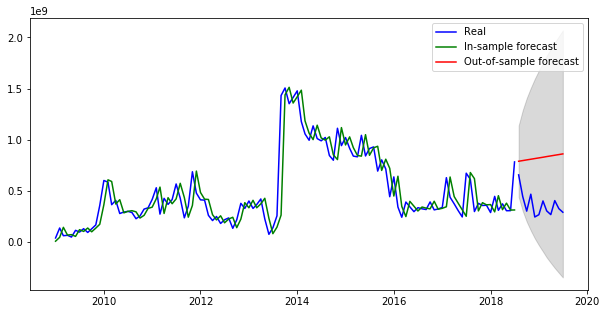

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2327.467
Date:                Wed, 04 Dec 2019   AIC                           4658.933
Time:                        17:16:32   BIC                           4664.406
Sample:                             0   HQIC                          4661.154
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.527e+06   1.67e+07      0.391      0.695   -2.62e+07    3.92e+07
sigma2      3.169e+16      0.123   2.58e+17      0.000    3.17e+16    3.17e+16
Ljung-Box (Q):                       31.57   Jarque-

In [0]:
x = arima(i = 1, train_y = train_cash, test_y = test_cash)

The data is very chaos, so I think maybe some assumptions of ARIMA were violated. Therefore, I run a dianogstic of normality assumption:

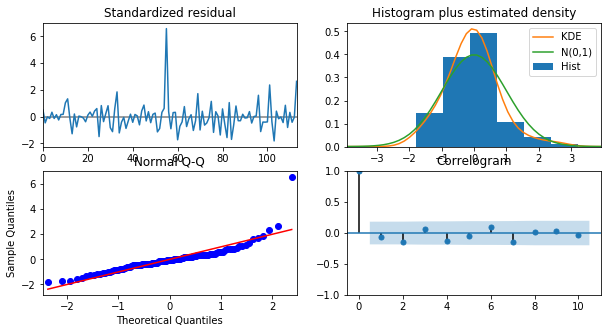

In [0]:
x.plot_diagnostics(figsize=(10, 5))
# plt.savefig(path + 'dia.png', quality = 100, dpi = 1000)
plt.show()

The forecasting residual does not look very normal, so I apply Box-Cox transformation to the raw data, hoping to normalize the data.

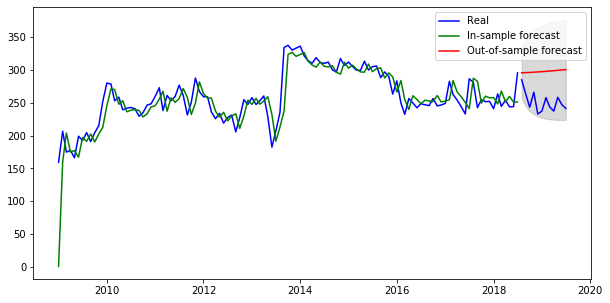

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -502.851
Date:                Wed, 27 Nov 2019   AIC                           1013.701
Time:                        18:45:36   BIC                           1024.646
Sample:                             0   HQIC                          1018.143
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0930      0.057      1.636      0.102      -0.018       0.205
ar.L1          0.8558      0.093      9.176      0.000       0.673       1.039
ma.L1         -0.9999     16.041     -0.062      0.9

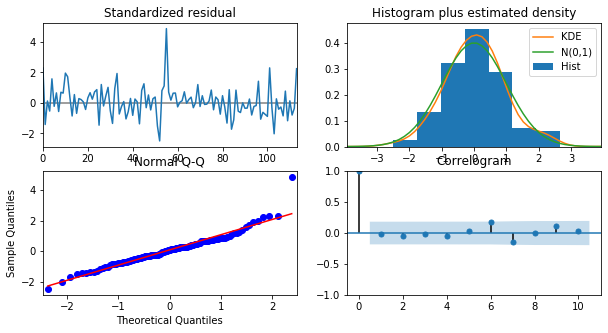

In [0]:
# ARIMA on Box-Cox cash i = 1
i = 1
train_cash_boxcox = pd.DataFrame(data=train_cash)
train_cash_boxcox.loc[:, i] = stats.boxcox(train_cash_boxcox[i], lmbda = 0.2)
test_cash_boxcox = pd.DataFrame(data=test_cash)
test_cash_boxcox.loc[:, i] = stats.boxcox(test_cash_boxcox[i], lmbda = 0.2)

cash_boxcox_model = arima(i, train_y = train_cash_boxcox, test_y = test_cash_boxcox)
cash_boxcox_model.plot_diagnostics(figsize=(10, 5))
# plt.savefig(path + 'dia.png', quality = 100, dpi = 1000)
plt.show()

In [0]:
# Invert Box-Cox
plt.figure(figsize= (10,5))
plt.plot(train_cash['Month'], train_cash[i], label = 'Real', color = 'blue')
plt.plot(test_cash['Month'], test_cash[i], color = 'blue')

insample_pred = inv_boxcox(cash_boxcox_model.predict_in_sample(), 0.2)
plt.plot(train_cash['Month'], insample_pred, label = 'In-sample forecast', color = 'green')

outsample_pred = inv_boxcox(cash_boxcox_model.predict(n_periods=12, return_conf_int = True)[0], 0.2)
lower_ci, upper_ci = inv_boxcox(cash_boxcox_model.predict(n_periods=12, return_conf_int = True)[1], 0.2).T

plt.plot(test_cash['Month'], outsample_pred, label = 'Out-of-sample forecast', color = 'red')
plt.fill_between(test_cash['Month'], lower_ci, upper_ci, color='k', alpha=.15)
plt.legend()
# plt.savefig(path + 'dia.png', quality = 100, dpi = 1000)
plt.show()

Observing the above graph, we see that Box-Cox transformation in this case doesn't help with the forecasting value, but it helps us to narrow down the confident interval. We will continue our analysis without Box-Cox transformation.

In [0]:
cash = pd.read_excel(raw, 'cash')
# Split data for model training at train_stop
train_stop = 115
train_interest = interest.iloc[:train_stop]
test_interest = interest.iloc[train_stop:]
train_cash = cash.iloc[:train_stop]
test_cash = cash.iloc[train_stop:]
train_rate = rate.iloc[:train_stop]
test_rate = rate.iloc[train_stop:]

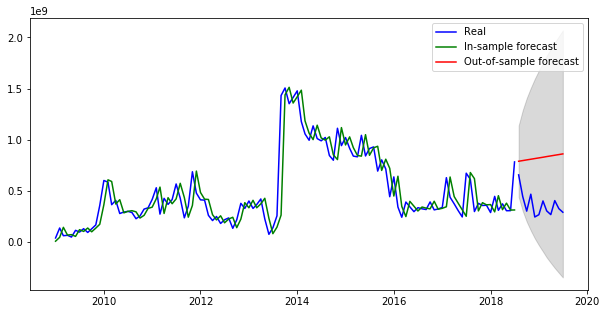

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2327.467
Date:                Wed, 04 Dec 2019   AIC                           4658.933
Time:                        17:16:58   BIC                           4664.406
Sample:                             0   HQIC                          4661.154
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.527e+06   1.67e+07      0.391      0.695   -2.62e+07    3.92e+07
sigma2      3.169e+16      0.123   2.58e+17      0.000    3.17e+16    3.17e+16
Ljung-Box (Q):                       31.57   Jarque-

In [0]:
# Cash forecast without Box-Cox
x = arima(i = 1, train_y = train_cash, test_y = test_cash)
outsample_pred_cash = x.predict(n_periods=12, return_conf_int = True)[0]

After forecasting 1 year ahead cash balance, we now need to forecast 1 year ahead FFR. Without having the information about inflation and GDP, ARIMA couldn't forecast FFR very well. We can improve the forecasting by incorporating inflation and GDP.

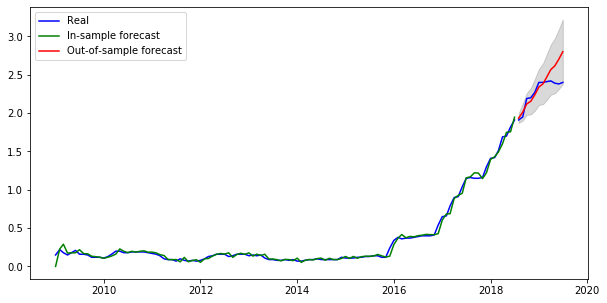

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 225.531
Date:                Wed, 04 Dec 2019   AIC                           -435.062
Time:                        17:17:08   BIC                           -413.243
Sample:                             0   HQIC                          -426.208
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      1.192      0.233      -0.001       0.004
ar.L1         -0.8106      0.153     -5.302      0.000      -1.110      -0.511
ar.L2         -0.7284      0.098     -7.466      0.0

In [0]:
ffr_model = arima(i = 'FFR', train_y = train_rate, test_y = test_rate)
outsample_pred_ffr = ffr_model.predict(n_periods=12, return_conf_int = True)[0]

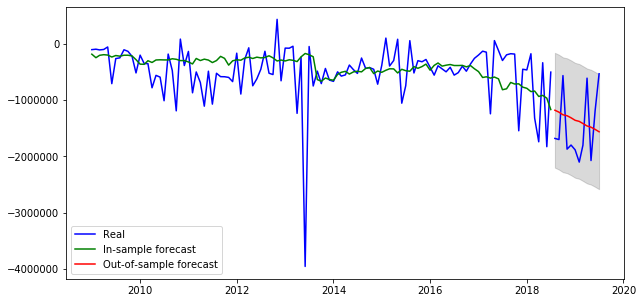

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                        SARIMAX   Log Likelihood               -1675.447
Date:                Wed, 04 Dec 2019   AIC                           3358.894
Time:                        17:17:19   BIC                           3369.874
Sample:                             0   HQIC                          3363.351
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.066e+05   2.81e-13   -3.8e+17      0.000   -1.07e+05   -1.07e+05
x1            -0.0003      0.000     -2.523      0.012      -0.001   -7.71e-05
x2         -4.138e+05   1.48e-13  -2.79e+18      0.0

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(0, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args=None,
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

In [0]:
# ARIMAX for i = 1
i = 1
train_x = pd.merge(train_cash[i], train_rate['FFR'], left_index=True, right_index=True)
test_x = pd.DataFrame(columns = [i, 'FFR'])
test_x[i] = outsample_pred_cash
test_x['FFR'] = outsample_pred_ffr

arima(i = i, train_y = train_interest, test_y = test_interest, train_x = train_x, test_x = test_x)

# **Section 5.3. Projection with Internal Data**

In [0]:
# Selecting i: 0, 1, 26, 29, 'ROW', 'UKplus'
i = 29

Cash Forecast 
        Month   0   1  26  29  UKplus  ROW
0 2019-08-01 NaN NaN NaN NaN     NaN  NaN
1 2019-09-01 NaN NaN NaN NaN     NaN  NaN
2 2019-10-01 NaN NaN NaN NaN     NaN  NaN
3 2019-11-01 NaN NaN NaN NaN     NaN  NaN
4 2019-12-01 NaN NaN NaN NaN     NaN  NaN
Rate Forecast 
        Month     0     1    26    29   ROW  UKplus
0 2019-08-01  2.13  2.13  2.13  5.40  2.13    2.13
1 2019-09-01  2.04  2.04  2.04  5.40  2.04    2.04
2 2019-10-01  1.83  1.83  1.83  5.15  1.83    1.83
3 2019-11-01  1.55  1.55  1.55  5.15  1.55    1.55
4 2019-12-01  1.75  1.75  1.75  5.15  1.75    1.75


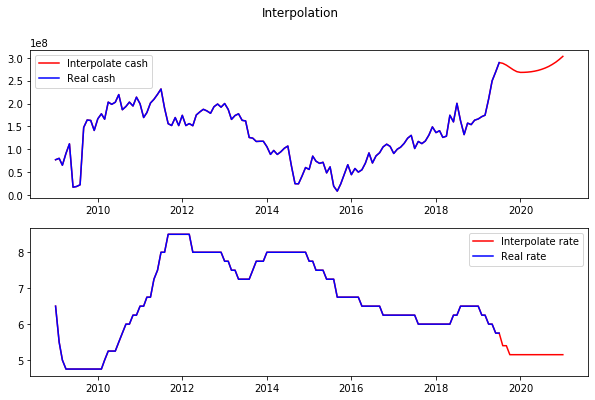

In [0]:
#@title **Data Interpolation** { run: "auto", vertical-output: true, display-mode: "form" }
# Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.tsa.stattools as stattools
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.statespace.sarimax as sarimax
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from contextlib import contextmanager
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os, sys

# Suppressing output of pip installation
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try: yield
        finally: sys.stdout = old_stdout
            
with suppress_stdout():
  ! pip install pmdarima
  ! pip install tbats
  from pmdarima import auto_arima
  from tbats import TBATS, BATS
  drive.mount('/content/gdrive')
  path = 'gdrive/My Drive/Colab Notebooks/InterestForecast/'
# Load raw data
raw = pd.ExcelFile(path + 'raw.xlsx')

# Primary variable
interest = pd.read_excel(raw, 'interest')
interest.name = 'interest'

# Secondary variable
cash = pd.read_excel(raw, 'cash')
cashForecast = pd.read_excel(raw, 'cashForecast')
rate = pd.read_excel(raw, 'rate')
rateForecast = pd.read_excel(raw, 'rateForecast')
# Aggregated interest across different entities
agg_interest = pd.DataFrame(data = interest, columns = ["Month", 0, 1, 26, 29, "ROW", "UKplus"])

UKplusInterest = pd.DataFrame(data = interest, columns = [25, 32, 37, 21, 33,
                                                          4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]) 
agg_interest["UKplus"] = UKplusInterest.sum(axis = 1)

ROWInterest = interest.drop(columns = ["Month", 2, 3,
                                       0, 1, 26, 29,
                                       25, 32, 37, 21, 33,
                                       4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17])
agg_interest["ROW"] = ROWInterest.sum(axis = 1)

# Aggregated cash across different entitites
agg_cash = pd.DataFrame(data = cash, columns = ["Month", 0, 1, 26, 29, "ROW", "UKplus"])

UKplusCash = pd.DataFrame(data = cash, columns = [25, 32, 37, 21, 33,
                                                  4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]) 
agg_cash["UKplus"] = UKplusCash.sum(axis = 1)

ROWCash = cash.drop(columns = ["Month", 2, 3, 19, 
                               0, 1, 26, 29,
                               25, 32, 37, 21, 33,
                               4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17])

agg_cash["ROW"] = ROWCash.sum(axis = 1)
print('Cash Forecast', '\n', cashForecast.head(5))
print('Rate Forecast', '\n', rateForecast.head(5))
# Merge cash and cashForecast
totalCash = agg_cash.append(cashForecast, sort = False)
totalCash = totalCash.reset_index(drop=True)

# Interpolate cash
totalCash_interpolate = totalCash.interpolate(method= 'pchip', limit_direction='both')
cashForecast_interpolate = totalCash_interpolate.tail(len(cashForecast))

# Merge rate and rateForecast
totalRate = rate.append(rateForecast, sort = False)
totalRate = totalRate.reset_index(drop = True)

# Interpolate rate 
totalRate_interpolate = totalRate.interpolate(method= 'pchip', limit_direction='both')
rateForecast_interpolate = totalRate_interpolate.tail(len(rateForecast))

# Plot interpolate data
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
fig.suptitle('Interpolation')

ax1.plot(totalCash_interpolate['Month'], totalCash_interpolate[i], label = 'Interpolate cash', color = 'red')
ax1.plot(agg_cash['Month'], agg_cash[i], label = 'Real cash', color = 'blue')
ax1.legend()

ax2.plot(totalRate_interpolate['Month'], totalRate_interpolate[i], label = 'Interpolate rate', color = 'red')
ax2.plot(rate['Month'], rate[i], label = 'Real rate', color = 'blue')
ax2.legend()

plt.show()

The total interest income at the end of forecasting period is -18979010.778568085  US dollars.

         Month            29
0  2019-08-01 -1.181280e+06
1  2019-09-01 -1.144961e+06
2  2019-10-01 -1.200016e+06
3  2019-11-01 -1.173709e+06
4  2019-12-01 -1.148594e+06
5  2020-01-01 -1.125177e+06
6  2020-02-01 -1.103150e+06
7  2020-03-01 -1.081872e+06
8  2020-04-01 -1.061353e+06
9  2020-05-01 -1.041601e+06
10 2020-06-01 -1.022626e+06
11 2020-07-01 -1.004440e+06
12 2020-08-01 -9.870517e+05
13 2020-09-01 -9.704731e+05
14 2020-10-01 -9.547155e+05
15 2020-11-01 -9.397908e+05
16 2020-12-01 -9.257114e+05
17 2021-01-01 -9.124899e+05 



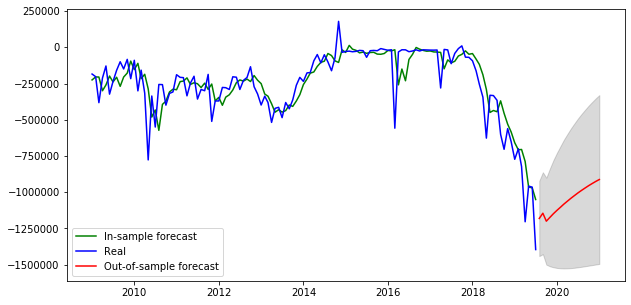

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -1675.640
Date:                Wed, 04 Dec 2019   AIC                           3367.279
Time:                        19:25:17   BIC                           3390.033
Sample:                             0   HQIC                          3376.524
                                - 127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8035.4461   7.59e-08  -1.06e+11      0.000   -8035.446   -8035.446
x1            -0.0004      0.000     -0.917      0.359      -0.001       0.001
x2          1.515e+04   2.37e-08    6.4e+11      0.0

In [0]:
#@title **Forecasting Result** { display-mode: "form" }
train_x = pd.merge(agg_cash[i], rate[i], left_index=True, right_index=True)

test_x = pd.DataFrame(columns = ['cash', 'rate'])
test_x['cash'] = cashForecast_interpolate[i]
test_x['rate'] = rateForecast_interpolate[i]

# Automatically fit model to train y
arima = auto_arima(agg_interest[i], exogenous = train_x,
                   start_p=0, d=None, start_q=0, max_p=5, max_d=2, max_q=5,
                   suppress_warnings = True)

# In-sample forecast
insample_pred = arima.predict_in_sample(exogenous = train_x)

# Multi-step out-of-sample forecast
outsample_pred = arima.predict(n_periods= len(test_x), exogenous = test_x, return_conf_int = True)
lower_ci, upper_ci = outsample_pred[1].T

# Total interest income
print('The total interest income at the end of forecasting period is', outsample_pred[0].sum(), ' US dollars.')

# Detail interest income 
forecastDetail = pd.DataFrame(columns = ['Month', i])
forecastDetail[i] = outsample_pred[0]
forecastDetail['Month'] = cashForecast_interpolate['Month'].values
print('\n', forecastDetail, '\n')

# Plot
plt.figure(figsize=(10,5))
plt.plot(agg_interest['Month'], insample_pred, label = 'In-sample forecast', color = 'green')
plt.plot(agg_interest['Month'], agg_interest[i], label = 'Real', color = 'blue')
plt.plot(cashForecast_interpolate['Month'], outsample_pred[0], label = 'Out-of-sample forecast', color = 'red')
plt.fill_between(cashForecast_interpolate['Month'], lower_ci, upper_ci, color='k', alpha=.15)
plt.legend()
plt.show()

# Model result
print(arima.summary())

# **Section 6. Auxiliary Analysis**

In [0]:
corr_table = pd.DataFrame(columns = ['i', 'Corr cash', 'Max corr cash', 'Lag cash', 'Corr ffr', 'Max corr ffr', 'Lag ffr'])

for i in range(0, 51):
  corr_table.loc[i, 'i'] = i
  corr_table.loc[i, 'Corr cash'] = interest[i].corr(cash[i])

for i in range(0, 51):
  max = 0
  for j in range(0,100):
    max_corr = interest[i].corr(cash[i].shift(-j))
    if abs(max_corr) > abs(max) :
      max = max_corr
      lag = j
  corr_table.loc[i, 'Lag cash'] = lag
  corr_table.loc[i, 'Max corr cash'] = max

for i in range(0, 51):
  corr_table.loc[i, 'Corr ffr'] = interest[i].corr(rate['FFR'])

for i in range(0, 51):
  max = 0
  for j in range(0,100):
    max_corr = interest[i].corr(rate['FFR'].shift(-j))
    if abs(max_corr) > abs(max) :
      max = max_corr
      lag = j
  corr_table.loc[i, 'Lag ffr'] = lag
  corr_table.loc[i, 'Max corr ffr'] = max

corr_table.head(10)

,i,Corr cash,Max corr cash,Lag cash,Corr ffr,Max corr ffr,Lag ffr
0,0,-0.150398,0.717744,60,-0.479884,-0.882948,91
1,1,0.0695437,0.329795,75,-0.470154,-0.565509,96
2,2,-0.267999,0.656701,61,-0.30604,-0.886853,90
3,3,-0.694,-0.694,0,0.77764,0.794235,1
4,4,-0.754365,-0.754365,0,-0.898189,-0.898189,0
5,5,-0.513186,-0.535994,4,-0.387648,-0.387648,0
6,6,-0.503002,0.636933,80,0.306499,-0.782481,89
7,7,0.00375118,0.536244,82,-0.537032,-0.609028,7
8,8,-0.014596,-0.541604,93,0.150524,0.587256,97
9,9,-0.735652,-0.805338,18,0.902543,0.956018,57
